1.0 INTRODUCTION:                                                                
Natural Language Processing (NLP) is widely used to interpret and classify human emotions from text data. This rapidly developing field employs various machine learning algorithms for sentiment analysis, identifying and categorizing emotional content in text. A state-of-the-art approach for this task involves using large language models like BERT aka Bidirectional Encoder Representations from Transformers, known for its strong contextual understanding (Pour, n.d.). NLP continues to evolve, with challenges in precisely interpreting and classifying human emotions from text data (Explanation of BERT Model – NLP, 2024).
This assignment outlines the process of creating, implementing, and refining a BERT-style language model tailored for emotion analysis. It involves methods for analyzing and cleaning a dataset with labeled emotional annotations and tokenizing text data meticulously. We focus on training with a tokenizer and a pre-trained BERT model, using AdamW optimization and CrossEntropyLoss for iterative learning and fine-tuning. The steps include preparing the data, developing the model, optimizing it, and evaluating its performance to classify emotions into positive or negative categories.

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving spam.csv to spam.csv


2.0 DATASET AND PRE-PROCESSING                                                        
The dataset used is the SMS spam collection dataset from Kaggle, containing 5,574 messages classified as spam (negative) or ham (positive). This set of data is usually used in tasks involving text classification to differentiate between authentic and non-authentic messages, offering a foundation for exploring NLP methods such as feature extraction and classification algorithms (SMS Spam Collection Dataset, n.d.).
After gathering the dataset, it undergoes pre-processing and cleaning for compatibility with the BERT model. Initially, the data is loaded, revealing two columns (V1 and V2) and three unnamed columns with null values. The columns V1 and V2 are renamed as Label (ham or spam) and Text, respectively, and the null columns are dropped. The labels are then converted into numeric values, mapping 'ham' to 0 and 'spam' to 1, suitable for machine learning algorithms.

In [ ]:
import pandas as pd
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Cleaning dataset

In [ ]:
data = data.rename(columns={'v1': 'label', 'v2': 'text'})

# Drop unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


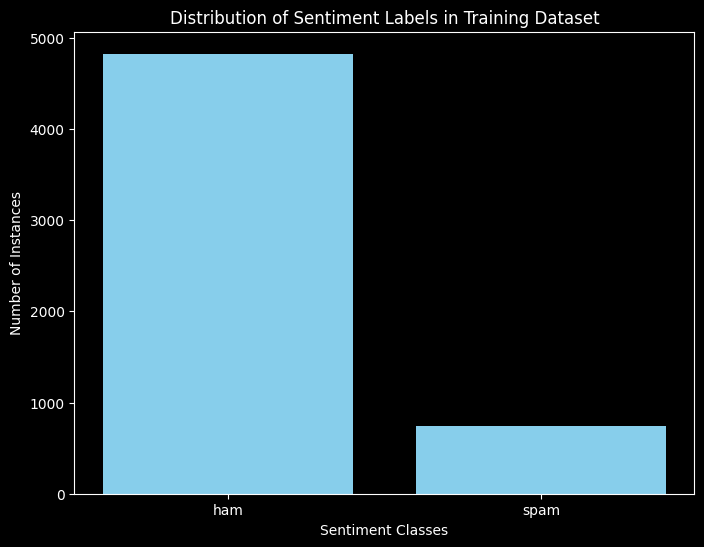

In [ ]:
import matplotlib.pyplot as plt
# Count the number of occurrences of each sentiment label
label_count = data['label'].value_counts().to_dict()

# Set style and figure size
plt.style.use("dark_background")
plt.figure(figsize=(8, 6))

# Plot bar chart
plt.bar(label_count.keys(), label_count.values(), color='skyblue')

# Set axis labels and title
plt.xlabel('Sentiment Classes')
plt.ylabel('Number of Instances')
plt.title('Distribution of Sentiment Labels in Training Dataset')

# Show plot
plt.show()

In [ ]:
#Map sentiment labels to integers
label_map = {'ham': 0, 'spam': 1}
data['label'] = data['label'].map(label_map)


3.0 TRAINING MODEL AND FINE TUNING                                                   
Before training, the set of data is split into training and testing data. 70% is meant for training and 30% for short-term usage, further divided into validation and test sets. Half of the temporary set is for testing and the other half for validation. Ultimately, 15% of the original dataset is for testing and 15% for validation.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
# specify GPU
device = torch.device("cuda")
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

3.1                                                                TRAINING begins by importing the transformers library and initializing the pre-trained BERT-base model and its tokenizer. The tokenizer converts text into a format the BERT model can understand. Text data from the test, validation, and training sets is encoded with a maximum sequence length of 25 tokens per message using the batch_encode_plus function. This involves truncating longer sequences and padding shorter ones for consistent input size.
PyTorch tensors represent the tokenized text sequences and attention masks. These tensors, along with labels and attention masks, are wrapped into datasets compatible with PyTorch's DataLoader, allowing effective batching and rearranging during training. A RandomSampler samples batches randomly for training data, while a SequentialSampler maintains order for validation data. The BERT_Arch model, a pre-trained BERT model, is used with some parameters frozen to avoid further training, focusing on fine-tuning added layers. The design includes two dense layers, a ReLU activation function, a dropout layer, and a LogSoftmax function for classification. Input sequences and attention masks are processed through BERT for contextual embeddings, further processed through activation functions and dense layers for final classification output.

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<Axes: >

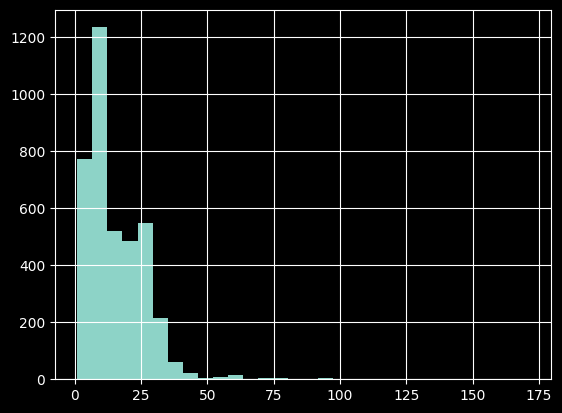

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

### 3.2 Tokenizing, Encoding and Converting to Tensors

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

Fine tuning model


In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

print('Class Weights:', class_weights)


Class Weights: [0.57743559 3.72848948]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

3.3 Training uses the AdamW optimizer, with the train() function moving each batch to the GPU (device). Labels, attention masks, and input sequences are extracted from the batch, and model.zero_grad() resets gradients. The model generates predictions, and cross-entropy loss measures the discrepancy between actual and predicted labels. Gradients are clipped using torch.nn.utils.clip_grad_norm_() to prevent explosion, and loss.backward() backpropagates the loss through the network. The optimizer adjusts the model's parameters with optimizer.step(). Predictions are sent to the CPU for further processing after being removed from the computation graph.

In [ ]:
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

def train():
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}.')

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


4.0 EVALUATING MODEL                                                           
The model runs for 10 epochs, calculating training loss, validation loss, training accuracy, and validation accuracy, which are chatted for performance understanding. After the 10th epoch, the validation accuracy is 87.56%, with a validation loss of 0.3927, lower than the training loss of 0.4259. The training accuracy is 69.72%, indicating the model's good performance, accurately classifying most classes.

In [ ]:
def evaluate():
    print("\nEvaluating...")

    model.eval()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,} of {len(val_dataloader):>5,}.')

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)

            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 1/10
Train Loss: 0.5712, Accuracy: 0.7044
Validation Loss: 0.5455, Accuracy: 0.8122
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 2/10
Train Loss: 0.5493, Accuracy: 0.6921
Validation Loss: 0.5217, Accuracy: 0.8493
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 3/10
Train Loss: 0.5290, Accuracy: 0.6869
Validation Loss: 0.5018, Accuracy: 0.8278
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 4/10
Train Loss: 0.5096, Accuracy: 0.7038
Validation Loss: 0.4836, Accuracy: 0.8337
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 5/10
Train Loss: 0.4958, Accuracy: 0.6887
Validation Loss: 0.4640, Accuracy: 0.8684
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 6/10
Train Loss: 0.4774, Accuracy: 0.7064
Validation Loss: 0.4497, Accuracy: 0.8349
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 7/10
Train Lo

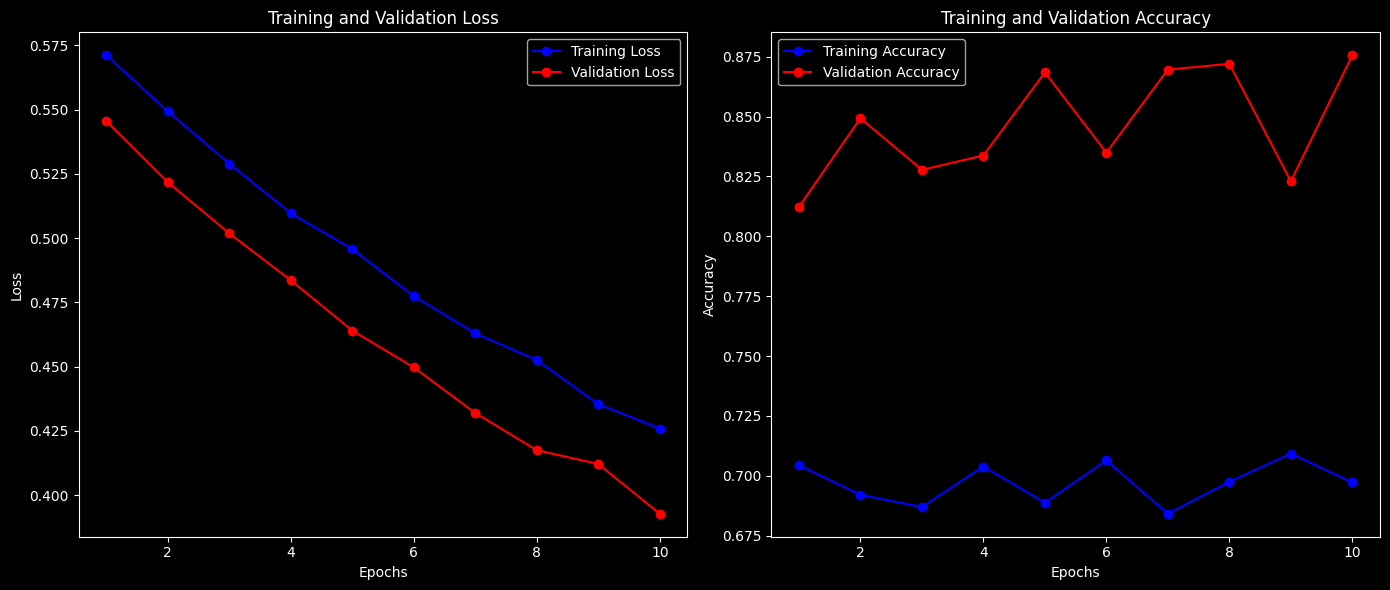

In [ ]:
import matplotlib.pyplot as plt

# Define number of epochs
epochs = 10

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    # Train the model
    train_loss, train_preds = train()  # Ensure train() returns predictions
    train_losses.append(train_loss)

    # Evaluate the model
    val_loss, val_preds = evaluate()
    val_losses.append(val_loss)

    # Calculate accuracy
    train_accuracy = accuracy_score(train_labels, np.argmax(train_preds, axis=1))
    val_accuracy = accuracy_score(val_labels, np.argmax(val_preds, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, 'o-', label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, 'o-', label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, 'o-', label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), val_accuracies, 'o-', label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


5.0 CONCLUSION                                                                
The discrepancy between training and validation metrics suggests areas for improvement, such as fine-tuning hyperparameters or increasing model complexity to boost training accuracy. Overall, the model shows strong classification performance, accurately distinguishing between classes. Future work could focus on enhancing training strategies and exploring advanced techniques to refine and optimize the model's performance further.

6.0 REFERENCES                                                              

Explanation of BERT Model – NLP. (2024, Jan 10). Retrieved from Geeks for geeks: https://www.geeksforgeeks.org/explanation-of-bert-model-nlp/         
Pour, C. H. (n.d.). BERT language model. Retrieved from Techtarget: https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model                                                         
SMS Spam Collection Dataset. (n.d.). Retrieved from Kaggle: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset